In [1]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

### Random baseline

In [2]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(1, num_rounds+1):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [3]:
REPS = ['1', '2']
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]
        #"adversarialBIM", "custom"
#ACQUISITION_FUNCTIONS = ["topuncertain"]
SCREEN_NAMES = ['IFNG']

num_reps = len(REPS)
sample_size=32
num_steps = 30

screen_name = SCREEN_NAMES[0]
data_name = screen_name.lower()

data_df = pd.read_csv('/dfs/user/yhr/research_assistant_orig/datasets/ground_truth_'+screen_name+'.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant_orig/datasets/topmovers_'+screen_name+'.npy')
all_genes = data_df['Gene'].values
data_df = data_df.set_index('Gene')

In [4]:
def get_random_hits(sample_size, num_steps = num_steps, num_reps=8):
    random_rounds = {}
    random_hits = {}
    random_hit_rates = {}

    for rep in range(1, num_reps+1):
        rep=str(rep)
        random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
        #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
        #                                                   sample_sizes=sample_sizes[rep])

        random_hits[rep] = []
        random_hit_rates[rep] = []
        for step in range(num_steps):
            random_hits[rep].append(return_hits(random_rounds[rep][step]))
            random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
            
    return random_hit_rates, random_hits

In [5]:
# calculate the mean and standard deviation of the random data
num_reps = 8
random_hit_rates, random_hits = get_random_hits(sample_size, num_steps = num_steps, num_reps=num_reps)
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)


### Claude

In [6]:
import glob
import os

fullobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_fullobs_IFNG/*/*step_29*')
noobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_noobs_IFNG/*/*step_29*')
onlyobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_onlyobs_IFNG/*/*step_29*')

fullobs_runs = ['/'.join(x.split('/')[:-1]) for x in fullobs_runs]
noobs_runs = ['/'.join(x.split('/')[:-1]) for x in noobs_runs]
onlyobs_runs = ['/'.join(x.split('/')[:-1]) for x in onlyobs_runs]

fullobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(fullobs_runs)}
noobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(noobs_runs)}
onlyobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(onlyobs_runs)}

num_reps = min(len(fullobs_exp_paths), len(noobs_exp_paths), len(onlyobs_exp_paths))

In [7]:
def get_mean_std_hitrate(exp_paths, num_reps=None, num_steps=num_steps):
    sampled_genes = {}
    sample_sizes = {}
    hits = {}
    hit_rates = {}
    num_rounds = num_steps
    num_steps = num_steps
    if num_reps is None:
        num_reps = len(exp_paths)
    filter_zero_sets = True
    min_rounds = num_steps

    for rep in exp_paths:
        sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep])
        sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
        if np.sum(np.array(sample_sizes[rep]) > 0) < min_rounds:
            sampled_genes.pop(rep, None)
            continue

        if filter_zero_sets:
             sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]

        hits[rep] = []
        hit_rates[rep] = []
        hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
        hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]

    num_steps_claude = np.min([len(x) for x in hit_rates.values()])
    
    ai_ra_mean_claude = np.mean([x[:num_steps_claude] for x in hit_rates.values()],0)
    ai_ra_std_claude = np.std(np.array([x[:num_steps_claude] for x in hit_rates.values()]),0)
    
    return ai_ra_mean_claude, ai_ra_std_claude

In [8]:
fullobs_mean, fullobs_std = get_mean_std_hitrate(fullobs_exp_paths, num_reps=num_reps)
noobs_mean, noobs_std = get_mean_std_hitrate(noobs_exp_paths, num_reps=num_reps)
onlyobs_mean, onlyobs_std = get_mean_std_hitrate(onlyobs_exp_paths, num_reps=num_reps)

### Plot result

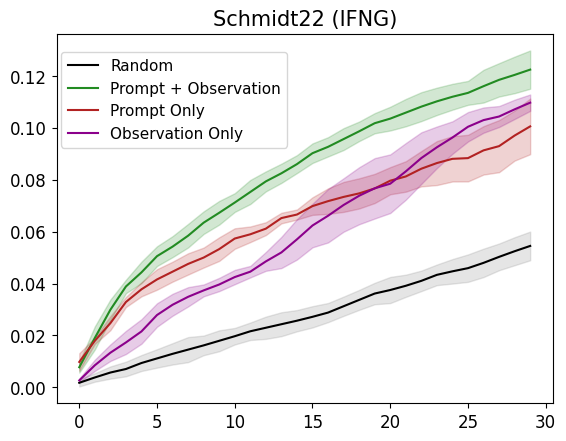

In [9]:
# create the plot
plt.plot(np.arange(num_steps), random_mean, label='Random', color='black')
plt.fill_between(np.arange(num_steps), random_mean - random_std, 
                         random_mean + random_std, alpha=0.2, color='gray')

forced_num_steps = num_steps
plot_ML = False
fontsize = 15

#colors = ['#00008B', '#8B0000', '#006400', '#008B8B', '#8B008B', '#808000', '#8B4500', '#4B0082', '#FF69B4', '#8B4513', '#00008B', '#8B0000', ]

itr=0
plt.plot(np.arange(num_steps), fullobs_mean[:num_steps], label='Prompt + Observation', color='forestgreen')
plt.fill_between(np.arange(num_steps), fullobs_mean[:num_steps] - fullobs_std[:num_steps], 
                         fullobs_mean[:num_steps] + fullobs_std[:num_steps], alpha=0.2, color='forestgreen')

plt.plot(np.arange(num_steps), noobs_mean[:num_steps], label='Prompt Only', color='firebrick')
plt.fill_between(np.arange(num_steps), noobs_mean[:num_steps] - noobs_std[:num_steps], 
                         noobs_mean[:num_steps] + noobs_std[:num_steps], alpha=0.2, color='firebrick')

plt.plot(np.arange(num_steps), onlyobs_mean[:num_steps], label='Observation Only', color='darkmagenta')
plt.fill_between(np.arange(num_steps), onlyobs_mean[:num_steps] - onlyobs_std[:num_steps], 
                         onlyobs_mean[:num_steps] + onlyobs_std[:num_steps], alpha=0.2, color='darkmagenta')

# set the x-axis labels and tick marks
plt.xlabel('', fontsize=fontsize)
plt.ylabel('', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add a legend to the plot
plt.legend(bbox_to_anchor=(0.48, 0.97), fontsize=11)

# display the plot
plt.title('Schmidt22 (IFNG)', fontsize=fontsize)
plt.savefig('prompt_obs_lineplot.svg')

plt.show()


### Comparing no-obs to obs+prompt

In [10]:
import glob
import os


step= 30
fullobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_fullobs_IFNG/*/*step_29*')
noobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_noobs_IFNG/*/*step_29*')
onlyobs_runs = glob.glob('/dfs/scratch0/andleerew/obsprompt_new/sonnet_onlyobs_IFNG/*/*step_29*')

fullobs_runs = ['/'.join(x.split('/')[:-1]) for x in fullobs_runs]
noobs_runs = ['/'.join(x.split('/')[:-1]) for x in noobs_runs]
onlyobs_runs = ['/'.join(x.split('/')[:-1]) for x in onlyobs_runs]

fullobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(fullobs_runs)}
noobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(noobs_runs)}
onlyobs_exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(onlyobs_runs)}

shared_num = min(len(fullobs_runs), len(noobs_runs))
print(shared_num)

8


In [11]:
sampled_genes = []
sampled_genes_1shot = []

for exp in [x +f'{step-1}.npy' for x in fullobs_exp_paths.values()][:shared_num]:
    sampled_genes.append(np.load(exp))

for exp in [x +f'{step-1}.npy' for x in noobs_exp_paths.values()][:shared_num]:
    sampled_genes_1shot.append(np.load(exp))

In [12]:
num = len(sampled_genes_1shot)
intersection_heatmap_1shot = np.zeros([num, num ])

for i in range(num):
    for j in range(num):
        intersection = len(set(sampled_genes_1shot[i]).intersection(set(sampled_genes_1shot[j])))
        union = len(set(sampled_genes_1shot[i]).union(set(sampled_genes_1shot[j])))
        intersection_heatmap_1shot[i][j] = intersection/union

In [13]:
num = len(sampled_genes)
intersection_heatmap = np.zeros([num, num ])

for i in range(num):
    for j in range(num):
        intersection = len(set(sampled_genes[i]).intersection(set(sampled_genes[j])))
        union = len(set(sampled_genes[i]).union(set(sampled_genes[j])))
        intersection_heatmap[i][j] = intersection/union

In [14]:
num_rows, num_cols = intersection_heatmap_1shot.shape

for i in range(min(num_rows, num_cols)):
    intersection_heatmap_1shot[i, i] = np.nan
    
num_rows, num_cols = intersection_heatmap.shape

for i in range(min(num_rows, num_cols)):
    intersection_heatmap[i, i] = np.nan



In [15]:
intersection_heatmap_1shot

array([[       nan, 0.23404255, 0.20794702, 0.21035169, 0.22416107,
        0.22416107, 0.21843687, 0.20912052],
       [0.23404255,        nan, 0.24335378, 0.23828921, 0.23410014,
        0.23160027, 0.24250681, 0.23815877],
       [0.20794702, 0.24335378,        nan, 0.22488038, 0.22739726,
        0.22154056, 0.2182189 , 0.23661017],
       [0.21035169, 0.23828921, 0.22488038,        nan, 0.22070845,
        0.21987747, 0.20999325, 0.21681121],
       [0.22416107, 0.23410014, 0.22739726, 0.22070845,        nan,
        0.21904762, 0.21409214, 0.2266308 ],
       [0.22416107, 0.23160027, 0.22154056, 0.21987747, 0.21904762,
               nan, 0.20917679, 0.22334004],
       [0.21843687, 0.24250681, 0.2182189 , 0.20999325, 0.21409214,
        0.20917679,        nan, 0.22252011],
       [0.20912052, 0.23815877, 0.23661017, 0.21681121, 0.2266308 ,
        0.22334004, 0.22252011,        nan]])

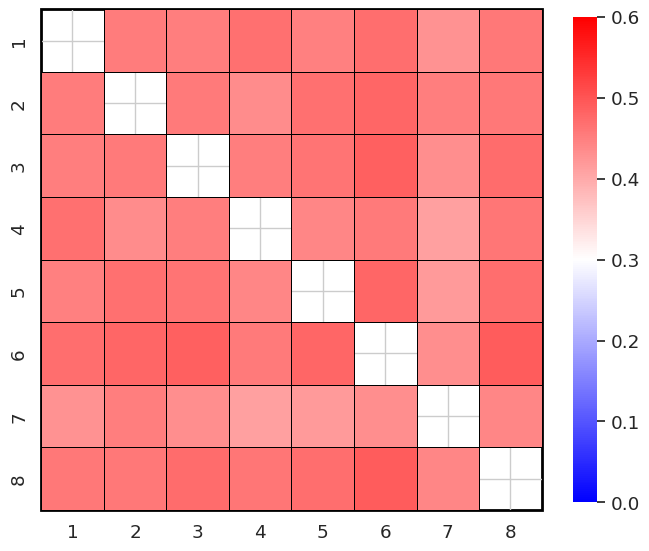

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Since the actual data is not provided, I will generate a random heatmap data as a placeholder.
# The following code will be based on this generated data.
data = intersection_heatmap

# Create a more professional heatmap for an academic paper
sns.set(style="whitegrid", font_scale=1.2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 0, as_cmap=True)
#cmap = sns.light_palette("reds", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data, cmap='bwr', vmin=0, vmax=.6, center=0.3,linecolor='black',
            square=True, linewidths=.5, cbar_kws={"shrink": .9})

# Set labels and title
plt.ylabel('')
plt.xlabel('')
plt.title('')

# Adding a border
ax.patch.set_edgecolor('black')  # Set the border color
ax.patch.set_linewidth(2)      # Set the border width

ax.set_xticklabels(np.arange(1, data.shape[1] + 1))
ax.set_yticklabels(np.arange(1, data.shape[0] + 1))


# Improve the appearance of the plot
plt.tight_layout()

# Save the figure
plt.savefig('./heatmap_full_obs.png')

# Show the plot
plt.show()


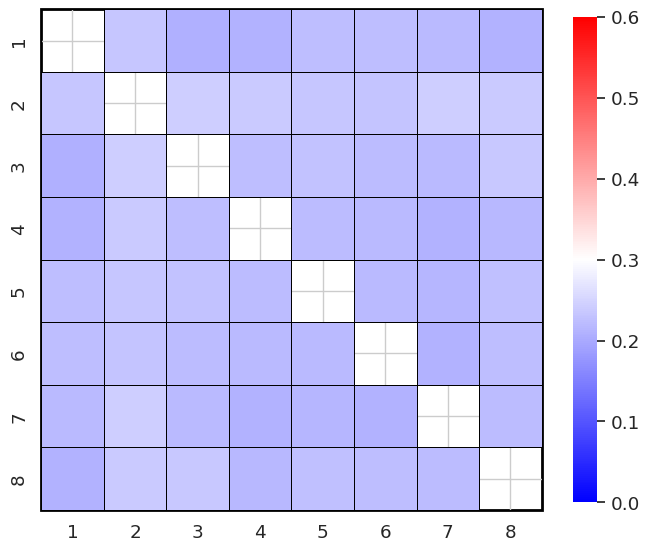

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Since the actual data is not provided, I will generate a random heatmap data as a placeholder.
# The following code will be based on this generated data.
data = intersection_heatmap_1shot

# Create a more professional heatmap for an academic paper
sns.set(style="whitegrid", font_scale=1.2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 0, as_cmap=True)
#cmap = sns.light_palette("reds", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data, cmap='bwr', vmin=0, vmax=.6, center=0.3, linecolor='black',
            square=True, linewidths=.5, cbar_kws={"shrink": .9})

# Set labels and title
plt.ylabel('')
plt.xlabel('')
plt.title('')

# Adding a border
ax.patch.set_edgecolor('black')  # Set the border color
ax.patch.set_linewidth(2)      # Set the border width

ax.set_xticklabels(np.arange(1, data.shape[1] + 1))
ax.set_yticklabels(np.arange(1, data.shape[0] + 1))


# Improve the appearance of the plot
plt.tight_layout()

# Save the figure
plt.savefig('./heatmap_no_obs.png')

# Show the plot
plt.show()
